In [1]:
import keras
import sys
sys.path.append('C:/Users/320060820/experiments/')
import os
import fxp_quantize
import model_data

from model_gen import keras_cnn
import copy

import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def brute_force_analysis(model_obj, name, test_data, layer_names, bw_range, f_range, 
                         fix_quant=False, parameters=None, eval_metric='acc_drop'):
    if fix_quant and parameters is None:
        raise ValueError('parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
        
    for i in range(len(layer_names)):
        
        scores_matrix = []
        
        for j in tnrange(len(bw_range), desc=f'BW Layer {layer_names[i]}', leave=False):
            
            scores_row = []
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):
                
                quant_params = {
                    layer_names[i]: [bw_range[j], f_range[k]]
                }
                if fix_quant:
                    quant_params = {**quant_params, **parameters}
                
                keras_model = model_data.Model(name, test_data, model=model_obj.get_fxp_model(quant_params))
                scores_row.append(keras_model.evaluate_accuracy()[1])
                
            scores_matrix.append(scores_row)
            
        scores = np.array(scores_matrix)

        if i == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {layer_names[i]} done.')
    
    model = model_data.Model(name, test_data, model=model_obj.get_float_model())
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
    
    return model_scores

In [2]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None, name=None):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])
    if name:
        plt.savefig(f'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Brute force results/{name}.png', 
                    bbox_inches='tight')

# CIFAR10

In [4]:
input_shape = (32, 32, 3)
num_outputs = 10 # number of classes
path_trained_weights = 'C:/Users/320060820/experiments/test_models/cifar_keras/cifar_keras_w.h5'
name = 'cifar_keras'

from test_models.cifar_keras import data
_, test_data = data.get_data()

keras_cifar = keras_cnn.KerasCNN(input_shape, num_outputs, path_trained_weights)

In [5]:
quant_params = {'conv2d_1': [3, 2], 'conv2d_2': [3, 4]}
keras_model = model_data.Model(name, test_data, model=keras_cifar.get_fxp_model(quant_params))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:
bw_range = np.arange(1, 11, 1)
f_range = np.arange(-4, 10, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']

In [6]:
scores_1 = brute_force_analysis(keras_cifar, name, test_data, layer_names, bw_range, f_range)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


## Results from experimentation

### Forward quantization

In [ ]:
parameters = {
    '2_1': {
        'conv2d_1': [7, 8]
    },
    '2_2': {
        'conv2d_1': [6, 7]
    },
    '2_3': {
        'conv2d_1': [5, 6]
    },
    '3': {
        'conv2d_1': [7, 8],
        'conv2d_2': [4, 1]
    },
    '4': {
        'conv2d_1': [7, 8],
        'conv2d_2': [4, 1],
        'conv2d_3': [5, 1]
    },
    '5': {
        'conv2d_1': [7, 8],
        'conv2d_2': [4, 1],
        'conv2d_3': [5, 1],
        'conv2d_4': [5, 0]
    }
}

In [4]:
load_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Activations/Keras_CIFAR10/'
scores_1 = np.load(load_path + 'scores_1.npy')
scores_2_1 = np.load(load_path + 'scores_2_1.npy')
scores_2_2 = np.load(load_path + 'scores_2_2.npy')
scores_2_3 = np.load(load_path + 'scores_2_3.npy') 
scores_3 = np.load(load_path + 'scores_3.npy')
scores_4 = np.load(load_path + 'scores_4.npy')
scores_5 = np.load(load_path + 'scores_5.npy')

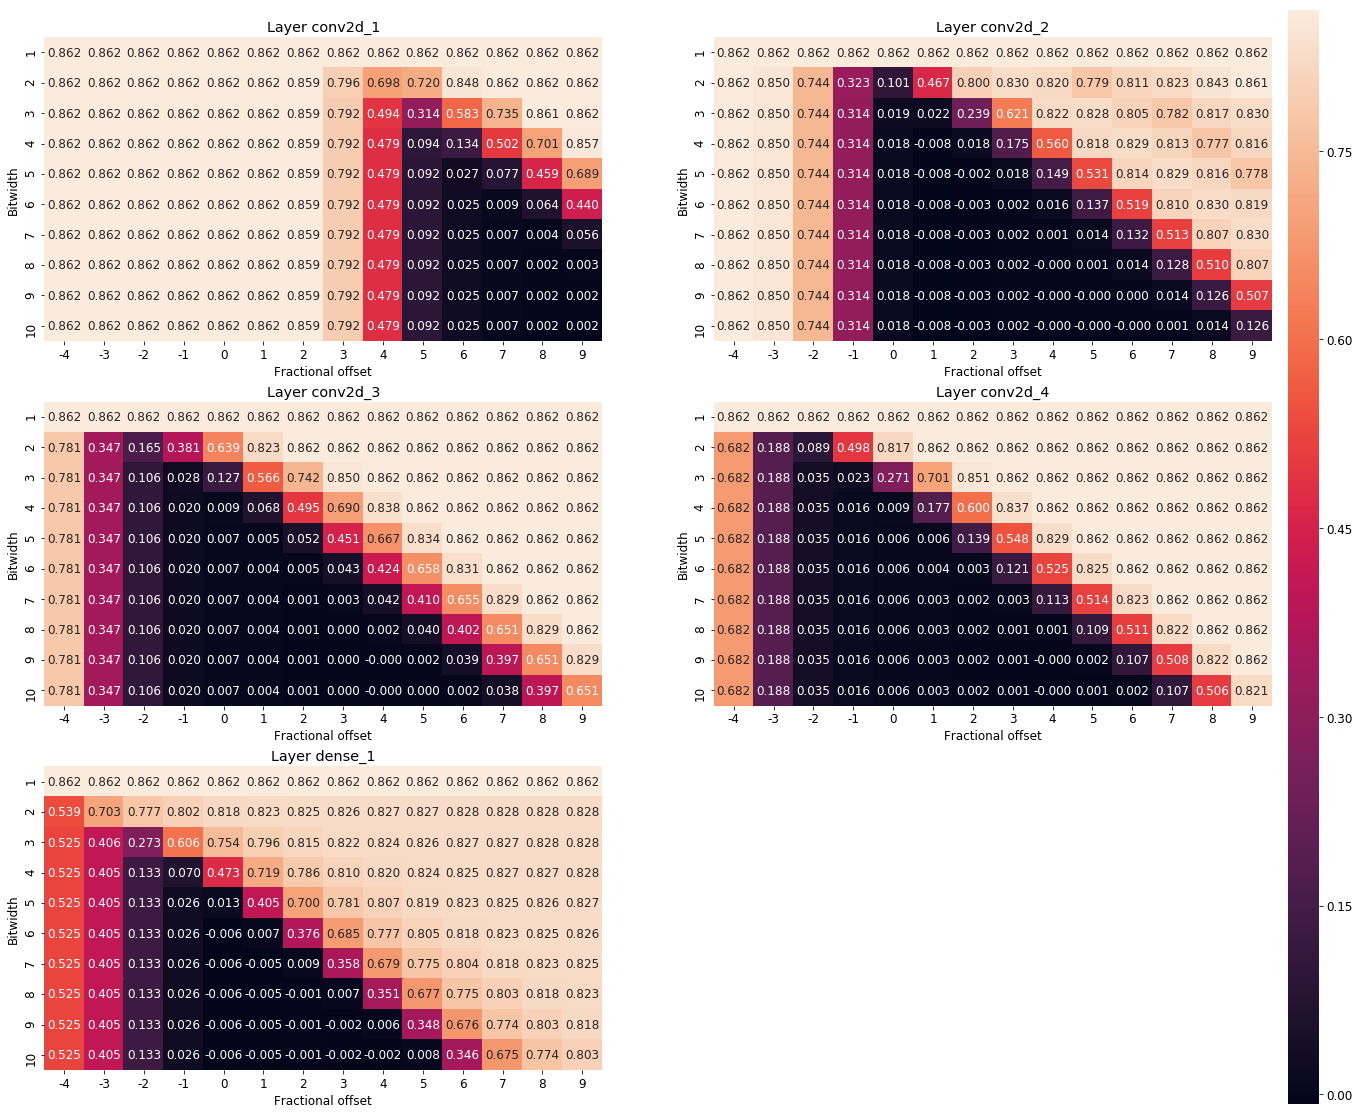

In [6]:
plot_results(scores_1, layer_names, 3, 2, (22, 19), 0.8, bw_range, f_range, name='keras_cifar10_a')

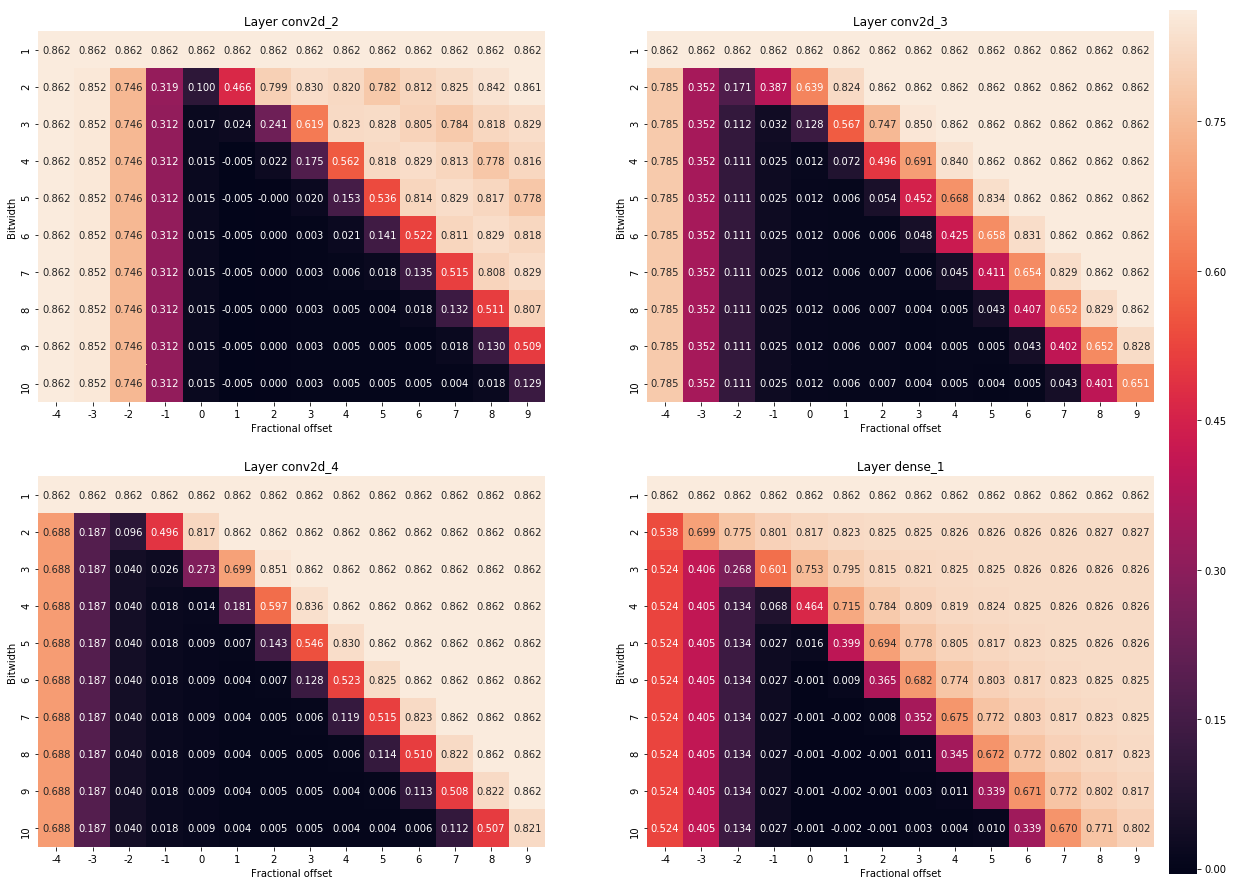

In [11]:
plot_results(scores_2_1, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range)

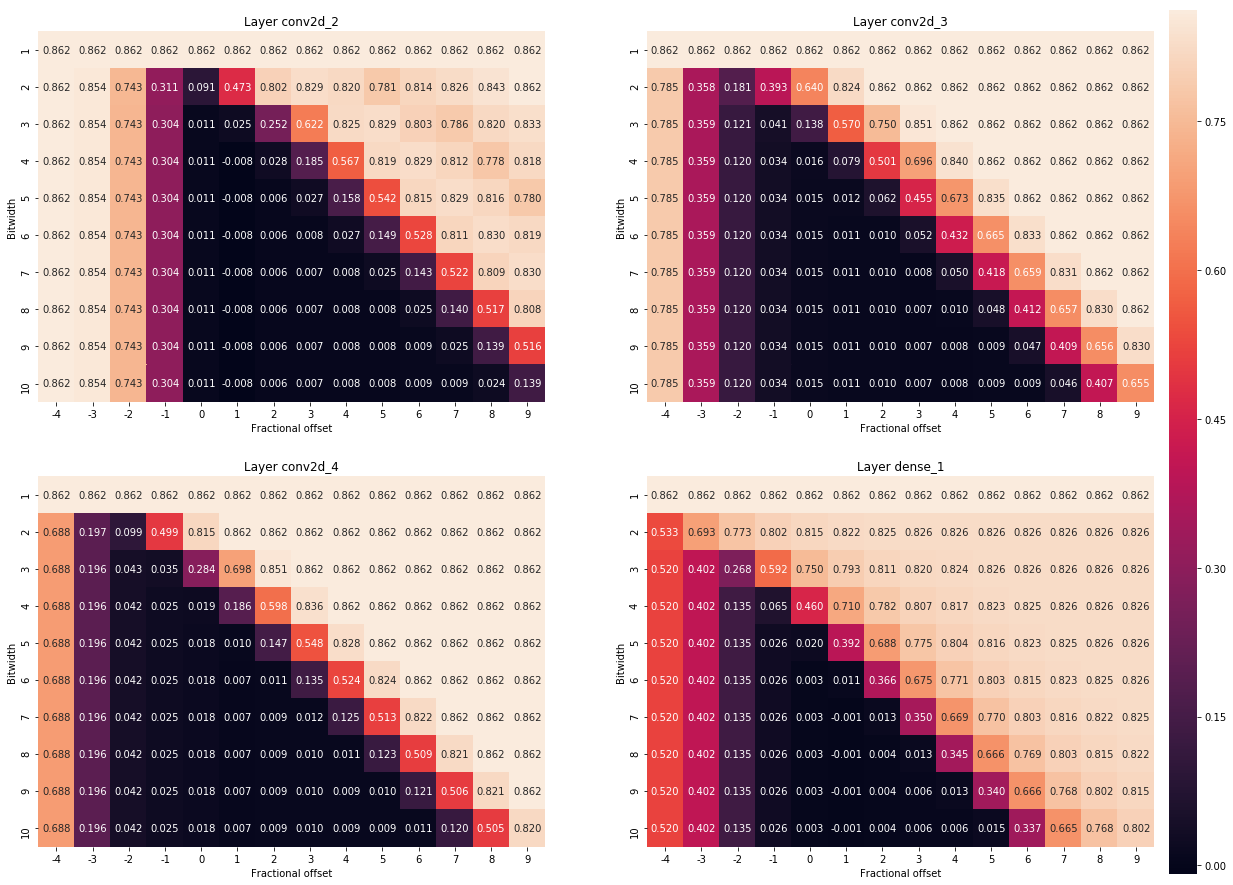

In [12]:
plot_results(scores_2_2, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range)

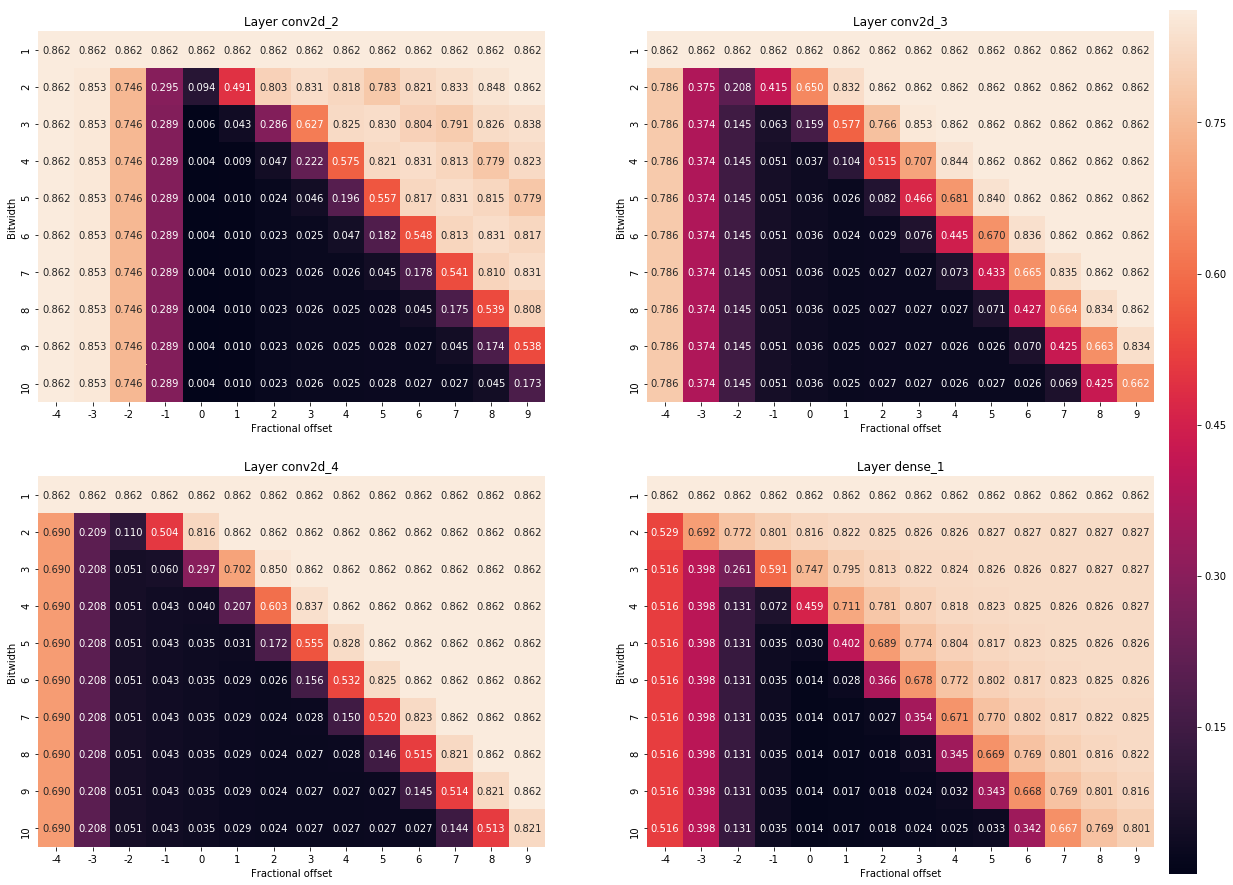

In [13]:
plot_results(scores_2_3, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range)

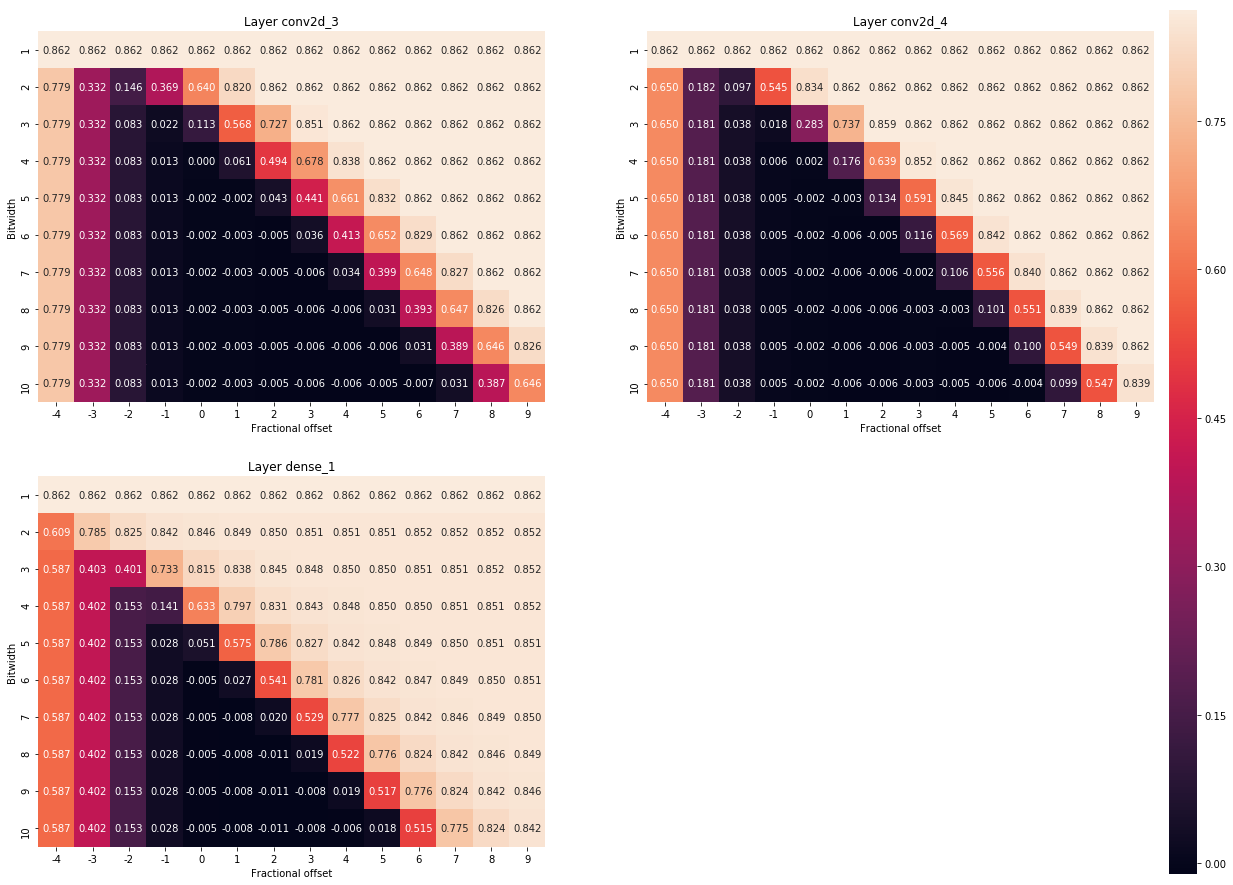

In [14]:
plot_results(scores_3, layer_names[2:], 2, 2, (20, 15), 0.8, bw_range, f_range)

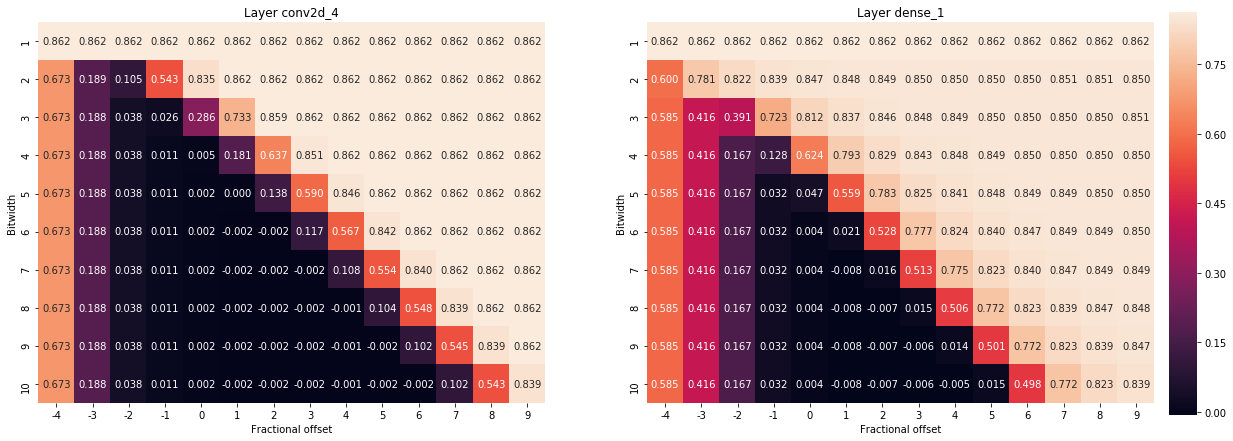

In [15]:
plot_results(scores_4, layer_names[3:], 1, 2, (20, 7), 0.8, bw_range, f_range)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


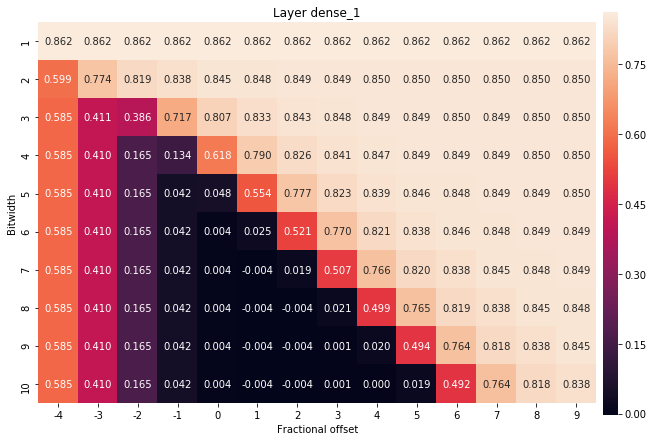

In [16]:
plot_results(scores_5, layer_names[4:], 1, 1, (10, 7), 0.8, bw_range, f_range)

##### Observations

- Quantization of activations seems to be independent as long as we quantize conservatively. Harsh quantization results in unpredictable behaviour, specifically that choosing a smaller bitwidth might result in some other layer later in the network having a different position for the optimum point, as compared to the optimum found from independent quantization. 
- When fixing the quantization for certain layers, the plots of the layers thereafter change ever so slightly as compared to if they were quantized independently. This deviation while harmless for the most part, may in some cases lead to the possibility of finding a better set of quantization parameters (characterized by lower bit-width mostly). This can be attributed to some margin of error or noise.
- For layer 3 in scores_3 we can see that our optimum choice goes from (5, 1) to (4, 0) where the former choice was made from our result of independent quantization of layer 3, and the latter was found after fixing quantization of layers 1 and 2 
- Our choice for BW and F for the layers leads us to a drop in inference accuracy of only 0.4% with sufficiently low bit-widths. 
- For the same drop in inference accuracy, for two different bit-widths and fractional offsets, it is better and safer to use the larger bit-width and/or fractional offset, in order to apply conservative quantization. The harsher quantization parameter might either lead to unpredictable behaviour, or worse inference accuracy values, when considering quantization of future layers.

#### Observing activations after quantization

In [33]:
keras_model = model_data.Model(name, test_data, model=keras_cifar.get_float_model())
print(f'Floating point model accuracy: {keras_model.evaluate_accuracy()[1]}')
act_maps_before_quant = keras_model.get_activation_maps(keras_model.x_test[0].reshape(1, 32, 32, 3), 'conv2d_2')

Floating point model accuracy: 0.7243


In [34]:
parameters = {
    'conv2d_1': [7, 8],
    'conv2d_2': [4, 1],
    'conv2d_3': [5, 1],
    'conv2d_4': [5, 0],
    'dense_1': [6, 0]
}
keras_model = model_data.Model(name, test_data, model=keras_cifar.get_fxp_model(parameters))
print(f'Quantized fixed-point model accuracy: {keras_model.evaluate_accuracy()[1]}')
act_maps_after_quant = keras_model.get_activation_maps(keras_model.x_test[0].reshape(1, 32, 32, 3), 'lambda_2')

Quantized fixed-point model accuracy: 0.7217


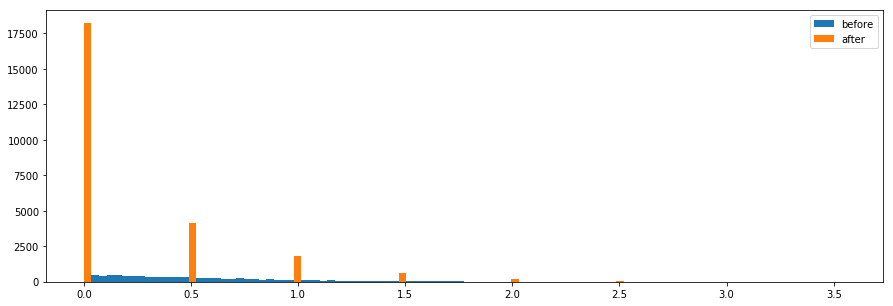

In [36]:
fig = plt.figure(figsize=(15, 5))
plt.hist(act_maps_before_quant.flat, bins=100, label='before');
plt.hist(act_maps_after_quant.flat, bins=100, label='after');
plt.legend()

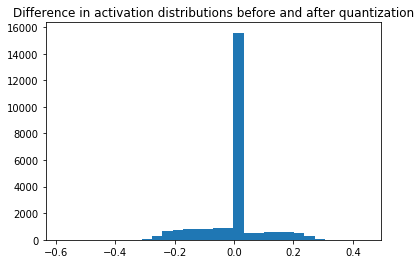

In [37]:
d = act_maps_after_quant - act_maps_before_quant
plt.hist(d.flat, bins=30);
plt.title('Difference in activation distributions before and after quantization');

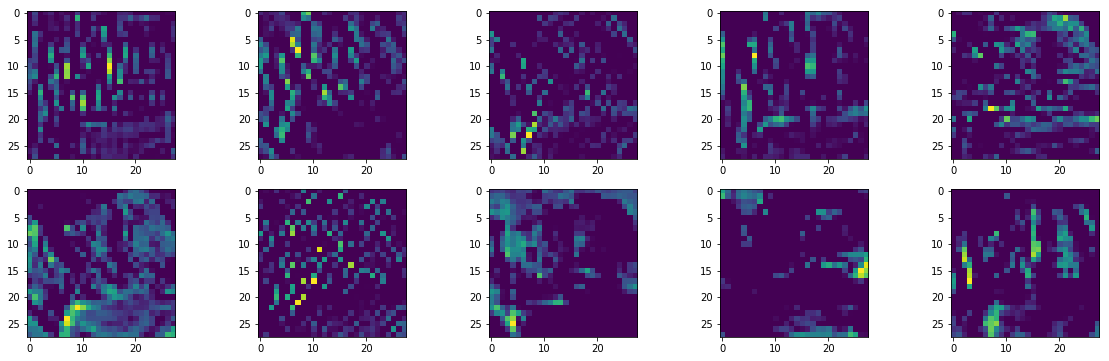

In [41]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
ax = axes.flat
for i in range(10):
    ax[i].imshow(act_maps_before_quant[0, :, :, i])

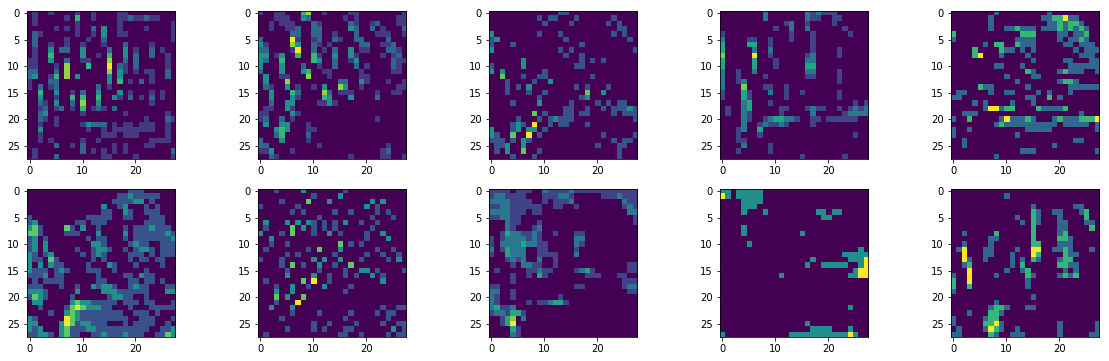

In [42]:
fig, axes = plt.subplots(2, 5, figsize=(20, 6))
ax = axes.flat
for i in range(10):
    ax[i].imshow(act_maps_after_quant[0, :, :, i])

### Reverse Quantization

In [52]:
parameters = {
    '1_1': {
        'dense_1': [6, 0]
    },
    '1_2': {
        'dense_1': [5, -1]
    },
    '2': {
        'conv2d_4': [5, 0],
        'dense_1': [6, 0]
    },
    '3': {
        'conv2d_3': [5, 1],
        'conv2d_4': [5, 0],
        'dense_1': [6, 0]
    },
    '4': {
        'conv2d_2': [4, 1],
        'conv2d_3': [5, 1],
        'conv2d_4': [5, 0],
        'dense_1': [6, 0]
    }
}

In [53]:
scores_r1_1 = brute_force_analysis(keras_cifar, name, test_data, layer_names[:-1], bw_range, f_range,
                                fix_quant=True, parameters=parameters['1_1'])
np.save(load_path + 'scores_r1_1', arr=scores_r1_1)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


In [55]:
scores_r1_2 = brute_force_analysis(keras_cifar, name, test_data, layer_names[:-1], bw_range, f_range,
                                fix_quant=True, parameters=parameters['1_2'])
np.save(load_path + 'scores_r1_2', arr=scores_r1_2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


In [56]:
scores_r2 = brute_force_analysis(keras_cifar, name, test_data, layer_names[:-2], bw_range, f_range,
                                fix_quant=True, parameters=parameters['2'])
np.save(load_path + 'scores_r2', arr=scores_r2)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


In [57]:
scores_r3 = brute_force_analysis(keras_cifar, name, test_data, layer_names[:-3], bw_range, f_range,
                                fix_quant=True, parameters=parameters['3'])
np.save(load_path + 'scores_r3', arr=scores_r3)

Layer conv2d_1 done.


Layer conv2d_2 done.


In [58]:
scores_r4 = brute_force_analysis(keras_cifar, name, test_data, layer_names[:-4], bw_range, f_range,
                                fix_quant=True, parameters=parameters['4'])
np.save(load_path + 'scores_r4', arr=scores_r4)

Layer conv2d_1 done.


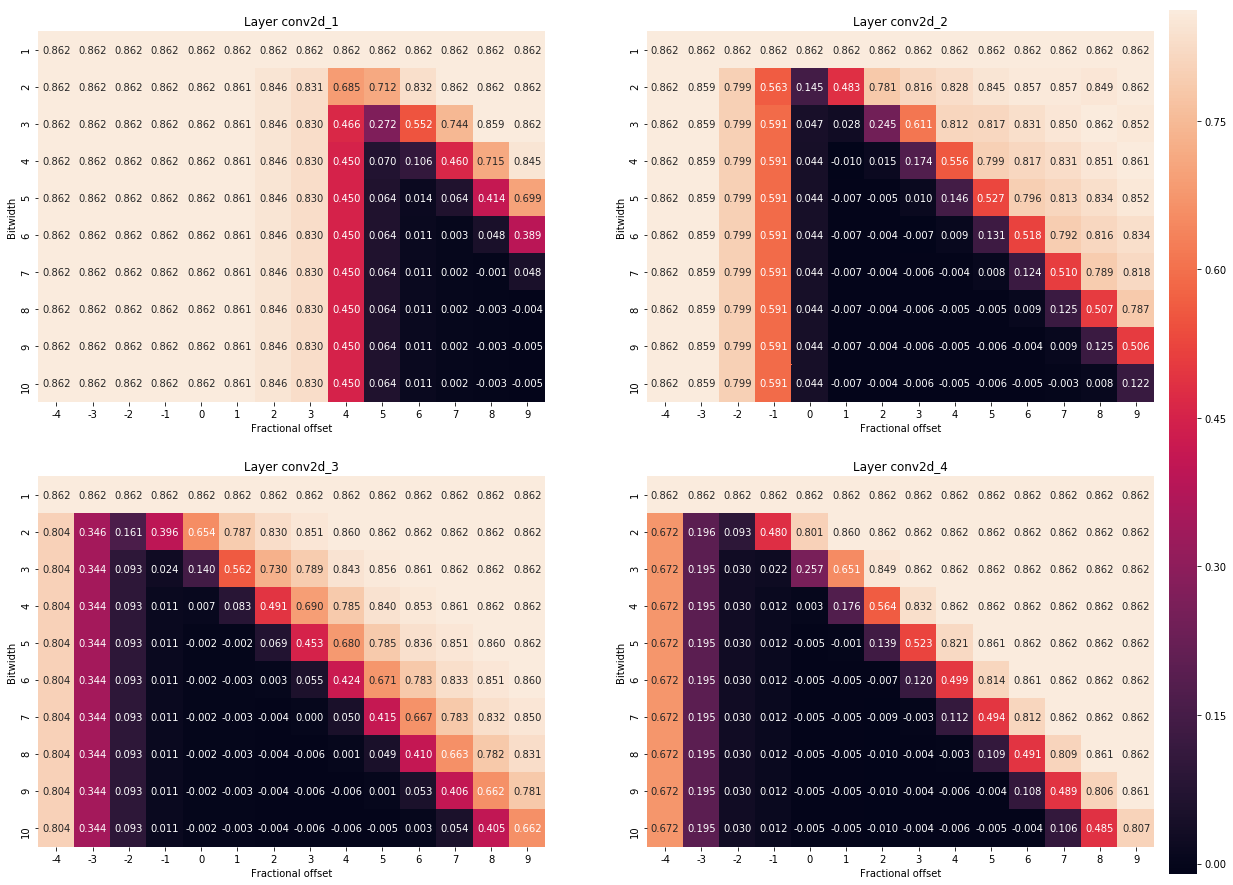

In [59]:
plot_results(scores_r1_1, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range)

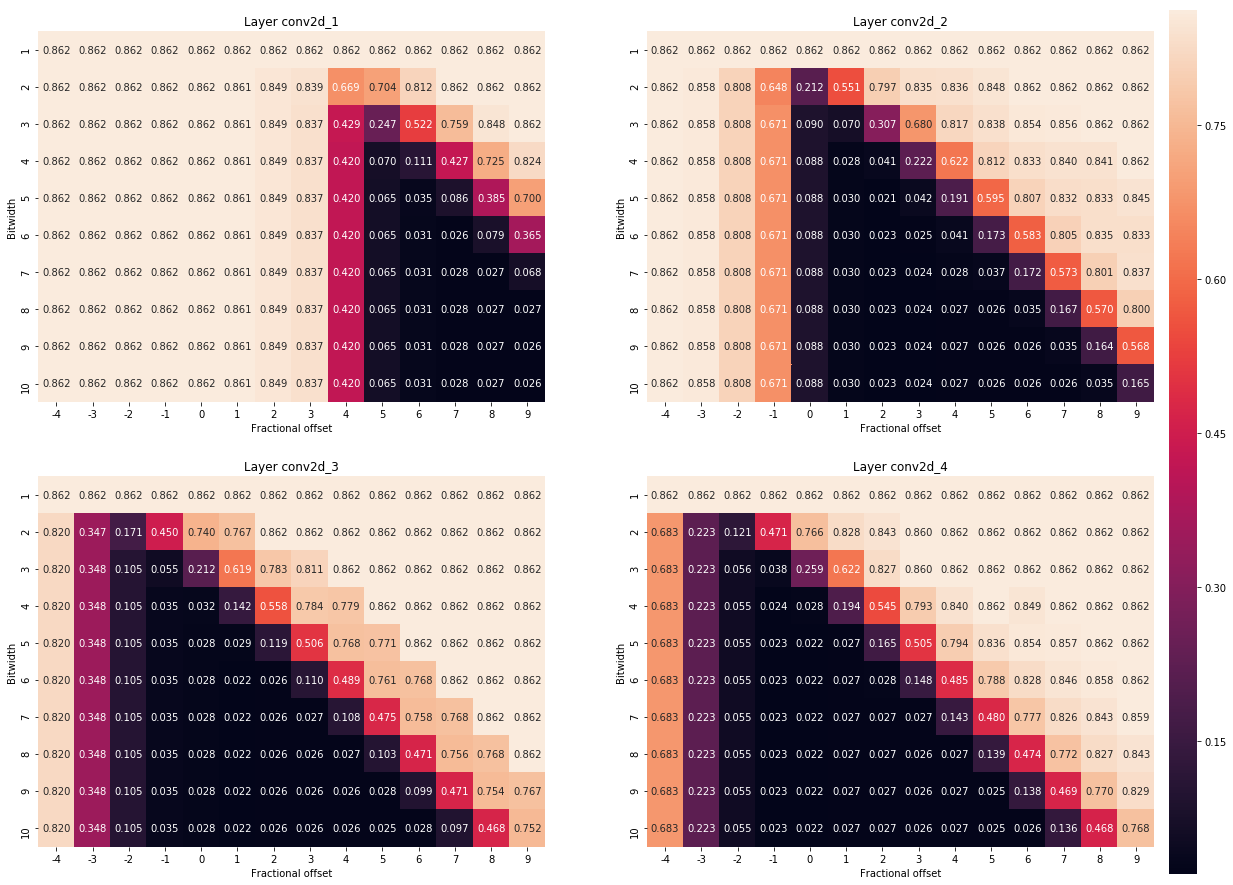

In [60]:
plot_results(scores_r1_2, layer_names[:-1], 2, 2, (20, 15), 0.8, bw_range, f_range)

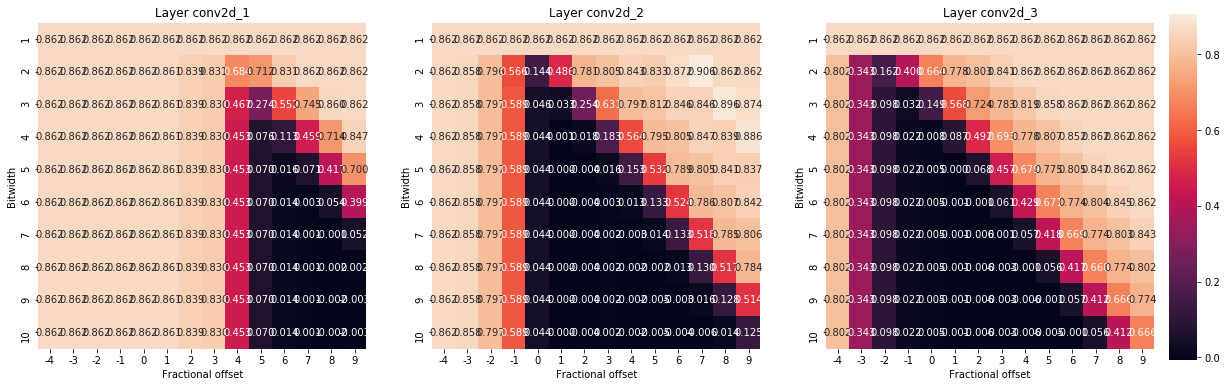

In [61]:
plot_results(scores_r2, layer_names[:-2], 2, 2, (20, 15), 0.8, bw_range, f_range)

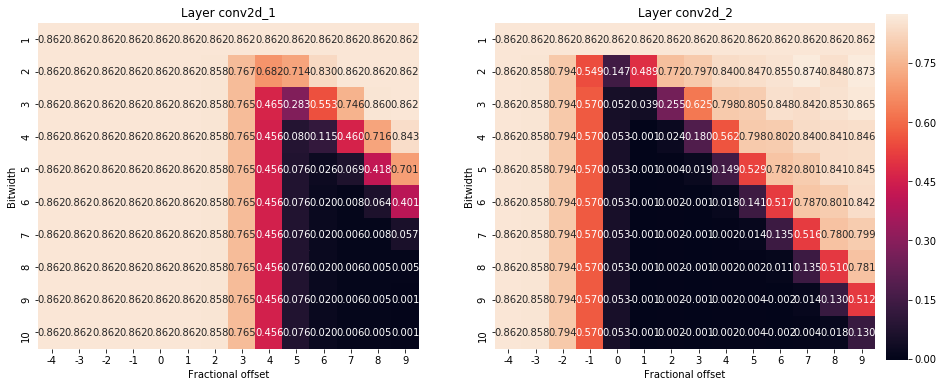

In [62]:
plot_results(scores_r3, layer_names[:-3], 1, 2, (20, 6), 0.8, bw_range, f_range)

C:\Users\320060820\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.


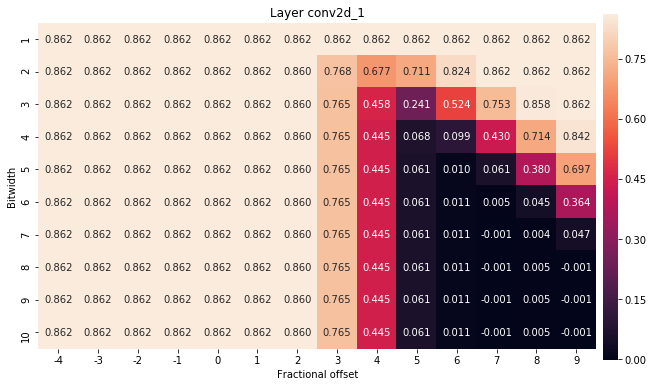

In [63]:
plot_results(scores_r4, layer_names[:-4], 1, 1, (10, 6), 0.8, bw_range, f_range)

##### Observations

- Quantization in reverse leads to the same result as that in forward. For the same point chosen, we end up with 0.4% inference accuracy drop. If we change our fractional offset, we might even be able to avoid this decrease in inference accuracy. This small improvement could be attributed to a statistical error/deviation or some level of noise. It is called so because this improvement of 0.1% for F = 7 is not something that was seen when quantizing layer 1 independently.